In [389]:
import sys
sys.path.append('../')
sys.path.append('./')
import DataGen
import technical_indicators as ti
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from strategy_test import strategy_test
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from itertools import compress
import json
import joblib
import untils
import ml_model as ml

This notebook provide an interface of leveraging machine learning to come up with a smarter strategy which combines multiple technique indicators to predict when to buy in crypto currencies.I picked some of the best performing technique indicators of each investing style catogories.<br/>
1. Volume indicators:<br/>
*OBV - On Balance Volume<br/>
2. Overlap indicators:<br/>
*BBANDS - Bollinger Bands<br/>
*SMA - Simple Moving Average<br/>
3. Momentum_indicators:<br/>
*ADXR - Average Directional Movement Index Rating<br/>
*RSI - Relative Strength Index<br/>
*STOCH - Stochastic Oscillator Slow<br/>
4. Volatility indicators:<br/>
*NATR - Normalized Average True Range<br/>
5. Statistic indicators:<br/>
*BETA - Beta<br/>
*LINEARREG_ANGLE - Linear Regression Angle<br/>
*STDDEV - Standard Deviation<br/>
6. Cycle_indicators:<br/>
*HT_TRENDMODE- Hilbert Transform - Trend vs Cycle Mode<br/>
*HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period<br/>
*HT_SINE - Hilbert Transform - SineWave<br/>
*HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase<br/>

In [2]:
dg=DataGen.DataGen('Gemini')
dg.load()

In [ ]:
windowsizes=[int(x) for x in np.linspace(1,90,90)]
responses=dg.get_leading_log_rt(windowsizes)
responses.dropna(inplace=True)
responses.tail()

In [4]:
data=dg.get_data()
tid=ti.technical_indicators(data)

In [391]:
window=30
tech=tid.get_composite_idts(ml.ml_config(window))
tech.dropna(inplace=True)
tech.drop(columns=['close'],inplace=True)
start=max(tech.index.min(),responses.index.min())
end=min(tech.index.max(),responses.index.max())
target='log_rt_'+str(window)
X=tech.loc[start:end,:]
Y=responses.loc[start:end,[target]]

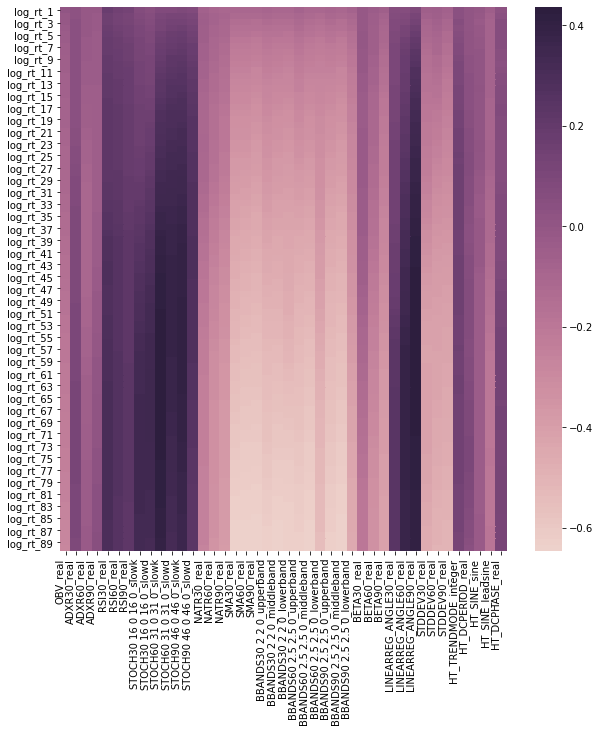

In [396]:
fig_name=target+'_Composite'
corr=utils.corr_plot(responses,tech,fig_name)

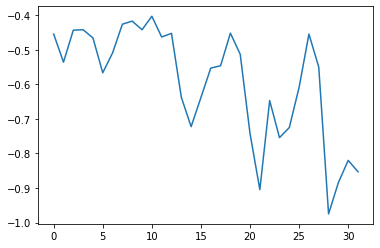

In [421]:
#tuning the hyper parameters
rf_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('RFregressor',RandomForestRegressor())
    ])

rf_param_grid = {
    'RFregressor__max_depth': [1,2,3,5],
    'RFregressor__max_features': [1,3],
    'RFregressor__n_estimators': [10,20,50,100]
}

RF_searcher=GridSearchCV(estimator=rf_est, param_grid=rf_param_grid,
                                  scoring='r2', n_jobs=1, cv=time_split)

RF_searcher.fit(X.values,Y.values.ravel())

plt.plot(RF_searcher.cv_results_['mean_test_score'])

In [423]:
ind=RF_searcher.cv_results_['mean_test_score']>-.5
list(compress(RF_searcher.cv_results_['params'], ind))

[{'RFregressor__max_depth': 1,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 10},
 {'RFregressor__max_depth': 1,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 50},
 {'RFregressor__max_depth': 1,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 100},
 {'RFregressor__max_depth': 1,
  'RFregressor__max_features': 3,
  'RFregressor__n_estimators': 10},
 {'RFregressor__max_depth': 1,
  'RFregressor__max_features': 3,
  'RFregressor__n_estimators': 100},
 {'RFregressor__max_depth': 2,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 10},
 {'RFregressor__max_depth': 2,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 20},
 {'RFregressor__max_depth': 2,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 50},
 {'RFregressor__max_depth': 2,
  'RFregressor__max_features': 1,
  'RFregressor__n_estimators': 100},
 {'RFregressor__max_depth': 2,
  'RFregressor__max_features': 3,
  'RFregressor__n_estim

In [424]:
RF_searcher.best_params_

{'RFregressor__max_depth': 2,
 'RFregressor__max_features': 1,
 'RFregressor__n_estimators': 50}

In [415]:
rf = RandomForestRegressor(n_estimators=RF_searcher.best_params_['RFregressor__n_estimators'],
                           max_depth=RF_searcher.best_params_['RFregressor__max_depth'],
                           max_features=RF_searcher.best_params_['RFregressor__max_features'])

In [416]:
rf_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('RFregressor',rf)
    ])

In [417]:
cv_scores = cross_val_score(rf_est, X.values, Y.values.ravel(), cv=time_split,
                            scoring='r2')

In [418]:
cv_scores

array([-1.76718939, -0.25531148, -0.08692033, -0.12068183, -0.6298997 ,
       -0.77767695, -1.31114797,  0.01288421,  0.3400235 , -0.21999261])

In [425]:
with open('./hypers/'+target+'_rf.json', 'w') as fp:
    json.dump(RF_searcher.best_params_, fp)

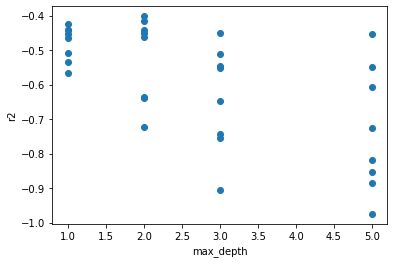

In [426]:

scaled_cv_results = RF_searcher.cv_results_
scaled_cv_accuracy = pd.DataFrame.from_dict(
    {'max_depth': [rec['RFregressor__max_depth'] for rec in scaled_cv_results['params']],
    'r2': scaled_cv_results['mean_test_score']})

plt.scatter(scaled_cv_accuracy.max_depth, scaled_cv_accuracy.r2, label="scaled_cv_r2")
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.show()

In [427]:
SVR_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('SVRregressor',SVR(gamma='scale',kernel='rbf'))
    ])
SVR_param_grid={'SVRregressor__C':[0.001,0.01,1,10],
               'SVRregressor__epsilon':[0.001,0.01,1,10]}
SVR_searcher=GridSearchCV(estimator=SVR_est, param_grid=SVR_param_grid,
                                  scoring='r2', n_jobs=1, cv=time_split)
SVR_searcher.fit(X.values,Y.values.ravel())

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('SVRregressor',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'SVRregressor__C': [0.001, 0.01, 1, 10],
                         'SVRregressor__epsilon': [0.001, 0.01, 1, 10]},
         

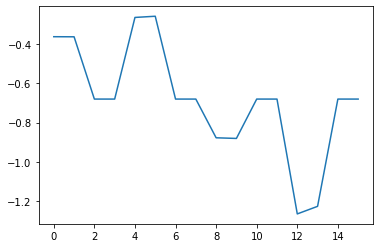

In [428]:
plt.plot(SVR_searcher.cv_results_['mean_test_score'])

In [429]:
ind=SVR_searcher.cv_results_['mean_test_score']>-.4
list(compress(SVR_searcher.cv_results_['params'], ind))

[{'SVRregressor__C': 0.001, 'SVRregressor__epsilon': 0.001},
 {'SVRregressor__C': 0.001, 'SVRregressor__epsilon': 0.01},
 {'SVRregressor__C': 0.01, 'SVRregressor__epsilon': 0.001},
 {'SVRregressor__C': 0.01, 'SVRregressor__epsilon': 0.01}]

In [430]:
SVR_searcher.best_params_

{'SVRregressor__C': 0.01, 'SVRregressor__epsilon': 0.01}

In [431]:
SVR_est=Pipeline([
    ('scaler',MinMaxScaler()), 
    ('SVRregressor',SVR(gamma='scale',kernel='rbf',C=SVR_searcher.best_params_['SVRregressor__C'],
                        epsilon=SVR_searcher.best_params_['SVRregressor__epsilon']))
    ])

In [432]:
cv_scores = cross_val_score(SVR_est, X.values, Y.values.ravel(), cv=time_split,
                            scoring='r2')

In [433]:
with open('./hypers/'+target+'_svr.json', 'w') as fp:
    json.dump(SVR_searcher.best_params_, fp)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.144272   -0.008207   0.623656
-0.118189    0.011875   0.716049
-0.092105    0.048542   0.906250
-0.066022    0.050940   0.920635
-0.039939    0.052875   0.935484
-0.013856    0.052875   0.935484
 0.010000    0.052875   0.935484
 0.012227    0.052875   0.935484
 0.020000    0.052598   0.934426
 0.038311    0.066274   1.000000
 0.064394    0.118457   1.000000
 0.090477    0.153212   1.000000
           avg_return  precision
boundary                        
-0.025131    0.115941   0.943820
-0.012867    0.121495   0.976744
-0.000603    0.125190   1.000000
 0.010000    0.118441   1.000000
 0.011662    0.117391   1.000000
 0.020000    0.106482   1.000000
 0.023926    0.105775   1.000000
 0.036190    0.112138   1.000000
 0.048454    0.122564   1.000000
 0.060718    0.130852   1.000000
 0.072983    0.148729   1.000000
 0.085247    0.150931   1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.100538    0.051958   0.775956
-0.074849    0.073900   0.865854
-0.049160    0.082602   0.904459
-0.023471    0.086872   0.922078
 0.002218    0.088110   0.928105
 0.010000    0.089144   0.934211
 0.020000    0.090897   0.946667
 0.027907    0.092905   0.959184
 0.053596    0.116662   1.000000
 0.079285    0.127319   1.000000
 0.104974    0.227170   1.000000
 0.130663    0.291751   1.000000
           avg_return  precision
boundary                        
-0.016846    0.095307   0.685393
-0.010892    0.088839   0.666667
-0.004938    0.086912   0.658537
 0.001017    0.078277   0.636364
 0.006971    0.063403   0.605634
 0.010000    0.055702   0.575758
 0.012925    0.040409   0.534483
 0.018879   -0.016733   0.428571
 0.020000   -0.024306   0.419355
 0.024833   -0.054574   0.318182
 0.030788   -0.027697   0.250000
 0.036742   -0.060669   0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.053775    0.066749   0.747253
-0.034205    0.080621   0.796875
-0.014635    0.089625   0.832653
 0.004935    0.091338   0.839506
 0.010000    0.092164   0.842975
 0.020000    0.101332   0.875536
 0.024505    0.104769   0.890830
 0.044075    0.111598   0.926941
 0.063646    0.125237   0.952381
 0.083216    0.172526   1.000000
 0.102786    0.225560   1.000000
 0.122356    0.243210   1.000000
          avg_return  precision
boundary                       
0.010000    0.239235   0.820225
0.020000    0.239235   0.820225
0.032501    0.239235   0.820225
0.043161    0.294300   0.876712
0.053821    0.275956   0.833333
0.064482    0.292430   0.886364
0.075142    0.369940   1.000000
0.085802    0.423695   1.000000
0.096462    0.423695   1.000000
0.107122    0.410814   1.000000
0.117782    0.291055   1.000000
0.128442    0.272822   1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.001542    0.109036   0.765840
 0.010000    0.116620   0.787535
 0.020000    0.127811   0.822485
 0.031412    0.136244   0.850153
 0.064367    0.160126   0.873646
 0.097321    0.239168   0.945455
 0.130276    0.327427   0.950617
 0.163230    0.390532   1.000000
 0.196184    0.400067   1.000000
 0.229139    0.451754   1.000000
 0.262093    0.488817   1.000000
 0.295048    0.480159   1.000000
          avg_return  precision
boundary                       
0.010000    0.235094   0.719101
0.020000    0.235094   0.719101
0.051083    0.235094   0.719101
0.059275    0.248151   0.722892
0.067467    0.268011   0.712329
0.075659    0.270520   0.714286
0.083851    0.272553   0.720588
0.092042    0.313447   0.789474
0.100234    0.376232   0.883721
0.108426    0.477527   1.000000
0.116618    0.564113   1.000000
0.124809    0.478295   1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


          avg_return  precision
boundary                       
0.010000    0.134372   0.757174
0.020000    0.134372   0.757174
0.031336    0.134372   0.757174
0.068957    0.155860   0.818616
0.106578    0.260895   0.898148
0.144199    0.371527   0.992248
0.181821    0.410817   1.000000
0.219442    0.438815   1.000000
0.257063    0.486010   1.000000
0.294684    0.534169   1.000000
0.332305    0.660982   1.000000
0.369927    0.619485   1.000000
          avg_return  precision
boundary                       
0.010000    0.332843   0.820225
0.020000    0.332843   0.820225
0.135890    0.332843   0.820225
0.153367    0.399684   0.893333
0.170844    0.389228   0.862069
0.188320    0.333346   0.789474
0.205797    0.492789   1.000000
0.223273    0.452296   1.000000
0.240750    0.462200   1.000000
0.258227    0.454747   1.000000
0.275703    0.415769   1.000000
0.293180    0.415769   1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.052592    0.166121   0.766114
-0.005587    0.177918   0.784906
 0.010000    0.178661   0.786389
 0.020000    0.179380   0.787879
 0.041417    0.179380   0.787879
 0.088421    0.198455   0.835366
 0.135425    0.285031   0.824373
 0.182430    0.360840   0.890909
 0.229434    0.462029   0.993421
 0.276438    0.564687   1.000000
 0.323442    0.762651   1.000000
 0.370447    0.765954   1.000000
          avg_return  precision
boundary                       
0.010000   -0.189139   0.224719
0.010114   -0.189139   0.224719
0.020000   -0.186488   0.229885
0.036863   -0.186032   0.232558
0.063611   -0.185388   0.238095
0.090360   -0.148911   0.259740
0.117109   -0.120786   0.277778
0.143858   -0.104635   0.294118
0.170606   -0.104635   0.294118
0.197355   -0.111073   0.301587
0.224104   -0.124923   0.259259
0.250852   -0.260701   0.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


           avg_return  precision
boundary                        
-0.200117    0.116108   0.690363
-0.143802    0.136584   0.712887
-0.087488    0.167349   0.765324
-0.031173    0.176416   0.786496
 0.010000    0.180205   0.789374
 0.020000    0.180205   0.789374
 0.025141    0.180205   0.789374
 0.081456    0.180734   0.790476
 0.137770    0.257727   0.825959
 0.194085    0.507737   1.000000
 0.250400    0.823331   1.000000
 0.306714    0.906966   1.000000
           avg_return  precision
boundary                        
-0.018505   -0.050219   0.359551
-0.005609   -0.051078   0.324324
 0.007286   -0.066539   0.296875
 0.010000   -0.080632   0.274194
 0.020000   -0.111148   0.214286
 0.020181   -0.111148   0.214286
 0.033076   -0.124163   0.176471
 0.045971   -0.142772   0.130435
 0.058866   -0.137605   0.138889
 0.071761   -0.176516   0.000000
 0.084656   -0.101536   0.000000
 0.097551   -0.022483   0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.193118    0.095884   0.650069
-0.141769    0.108860   0.662906
-0.090421    0.129288   0.696296
-0.039073    0.153679   0.740132
 0.010000    0.171544   0.776596
 0.012276    0.171196   0.776199
 0.020000    0.172991   0.780357
 0.063624    0.179940   0.791745
 0.114972    0.212062   0.819820
 0.166321    0.469915   1.000000
 0.217669    0.634227   1.000000
 0.269017    0.906966   1.000000
          avg_return  precision
boundary                       
0.010000   -0.008845   0.426966
0.020000   -0.008845   0.426966
0.067217   -0.008845   0.426966
0.074728   -0.010709   0.430233
0.082238   -0.026755   0.402597
0.089749   -0.034848   0.343284
0.097260   -0.033652   0.346939
0.104771   -0.032645   0.281250
0.112282   -0.032202   0.217391
0.119792   -0.076270   0.166667
0.127303   -0.110865   0.000000
0.134814   -0.103021   0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.206921    0.084240   0.624846
-0.158537    0.095065   0.635000
-0.110152    0.103316   0.647959
-0.061768    0.119719   0.674635
-0.013383    0.146761   0.727820
 0.010000    0.153175   0.738510
 0.020000    0.154778   0.744715
 0.035001    0.164580   0.756140
 0.083386    0.181026   0.788054
 0.131770    0.256876   0.876404
 0.180155    0.549169   1.000000
 0.228539    0.906966   1.000000
          avg_return  precision
boundary                       
0.010000   -0.180911   0.224719
0.020000   -0.180911   0.224719
0.049087   -0.180911   0.224719
0.061253   -0.232067   0.261538
0.073420   -0.239226   0.253968
0.085586   -0.230289   0.285714
0.097752   -0.151739   0.375000
0.109918   -0.188051   0.428571
0.122084   -0.379346   0.266667
0.134250   -0.536170   0.000000
0.146417   -0.501603   0.000000
0.158583   -0.537561   0.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.191656    0.057902   0.584718
-0.149938    0.077078   0.602740
-0.108219    0.090191   0.619718
-0.066501    0.114400   0.659548
-0.024783    0.168470   0.768707
 0.010000    0.173070   0.776965
 0.016936    0.173254   0.776147
 0.020000    0.173214   0.775735
 0.058654    0.176281   0.786792
 0.100373    0.187379   0.778926
 0.142091    0.272152   0.788462
 0.183809    0.670943   1.000000
          avg_return  precision
boundary                       
0.010000    0.069098   0.696629
0.020000    0.069098   0.696629
0.062453    0.069098   0.696629
0.068299    0.083031   0.765432
0.074146    0.132108   0.950000
0.079992    0.148590   0.979592
0.085839    0.194185   1.000000
0.091685    0.215952   1.000000
0.097532    0.222365   1.000000
0.103378    0.222421   1.000000
0.109225    0.071301   1.000000
0.115071    0.068856   1.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.151985    0.059136   0.595166
-0.115752    0.075328   0.612435
-0.079519    0.094152   0.634801
-0.043286    0.114879   0.672941
-0.007053    0.142659   0.741935
 0.010000    0.158058   0.767442
 0.020000    0.160125   0.769231
 0.029180    0.161710   0.774092
 0.065413    0.179639   0.802842
 0.101646    0.191786   0.784585
 0.137879    0.358994   0.844720
 0.174112    0.442396   1.000000
          avg_return  precision
boundary                       
0.010000    0.288434        1.0
0.020000    0.288434        1.0
0.060844    0.288434        1.0
0.071281    0.293618        1.0
0.081718    0.297429        1.0
0.092154    0.296419        1.0
0.102591    0.295672        1.0
0.113028    0.291355        1.0
0.123465    0.283335        1.0
0.133901    0.288394        1.0
0.144338    0.247241        1.0
0.154775    0.161568        1.0


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.184024    0.078043   0.628809
-0.143892    0.086528   0.637044
-0.103761    0.098543   0.651675
-0.063630    0.122828   0.687879
-0.023498    0.151117   0.754673
 0.010000    0.177003   0.800830
 0.016633    0.177403   0.801939
 0.020000    0.177403   0.801939
 0.056764    0.184028   0.815296
 0.096895    0.198526   0.824841
 0.137027    0.232473   0.851779
 0.177158    0.674233   1.000000
           avg_return  precision
boundary                        
-0.035340   -0.082914   0.224719
-0.025035   -0.079472   0.229885
-0.014729   -0.071478   0.250000
-0.004423   -0.065938   0.266667
 0.005883   -0.064153   0.276923
 0.010000   -0.070561   0.250000
 0.016189   -0.028170   0.310345
 0.020000   -0.015320   0.368421
 0.026494   -0.032904   0.200000
 0.036800    0.100297   1.000000
 0.047106    0.100297   1.000000
 0.057412    0.133110   1.000000


/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packag

           avg_return  precision
boundary                        
-0.159020    0.065559   0.597613
-0.119635    0.076517   0.608507
-0.080251    0.092417   0.625893
-0.040866    0.129939   0.701431
-0.001482    0.162023   0.771465
 0.010000    0.171965   0.789757
 0.020000    0.173826   0.796196
 0.037902    0.174756   0.796448
 0.077287    0.178957   0.805049
 0.116671    0.220697   0.819703
 0.156056    0.426403   1.000000
 0.195440    0.762163   1.000000
           avg_return  precision
boundary                        
-0.084343   -0.047748   0.449438
-0.078033   -0.046976   0.453488
-0.071723   -0.039934   0.475610
-0.065413   -0.027615   0.507042
-0.059102   -0.005136   0.568966
-0.052792   -0.023661   0.543478
-0.046482   -0.048251   0.466667
-0.040172   -0.057187   0.300000
-0.033862   -0.055010   0.000000
-0.027552   -0.055010   0.000000
 0.010000    0.000000   0.000000
 0.020000    0.000000   0.000000


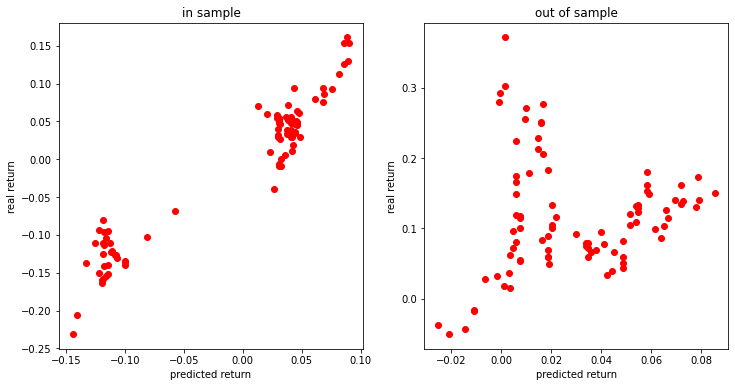

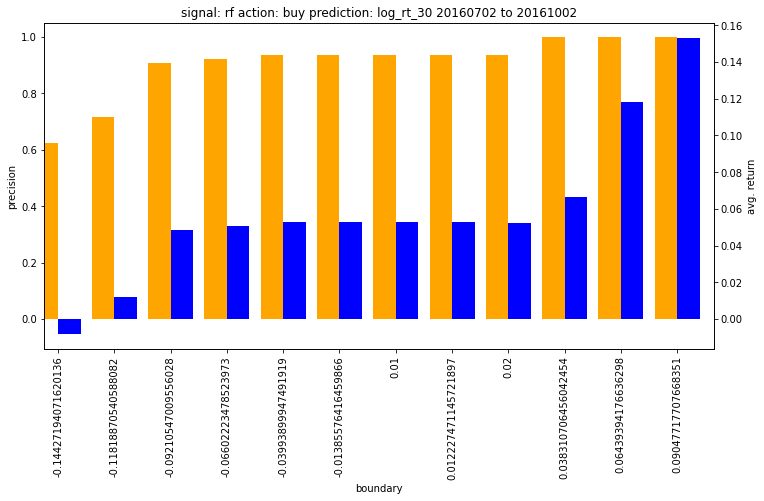

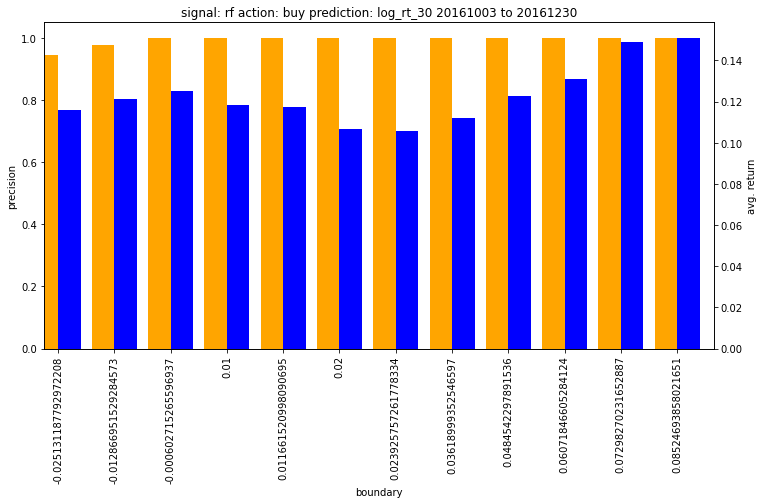

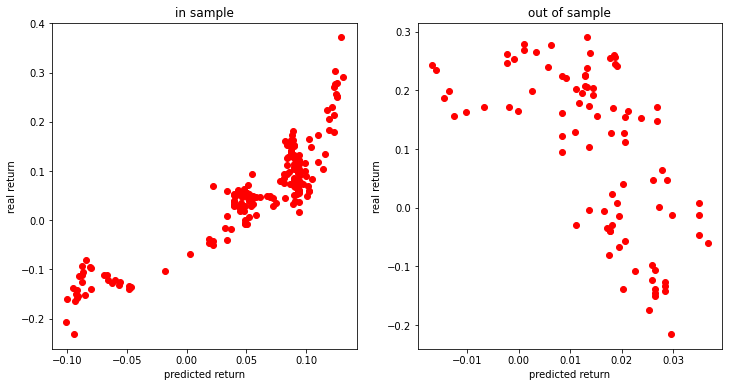

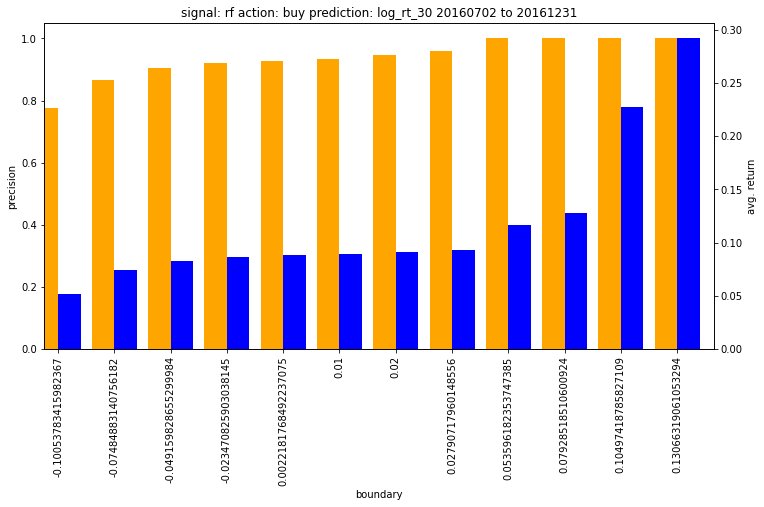

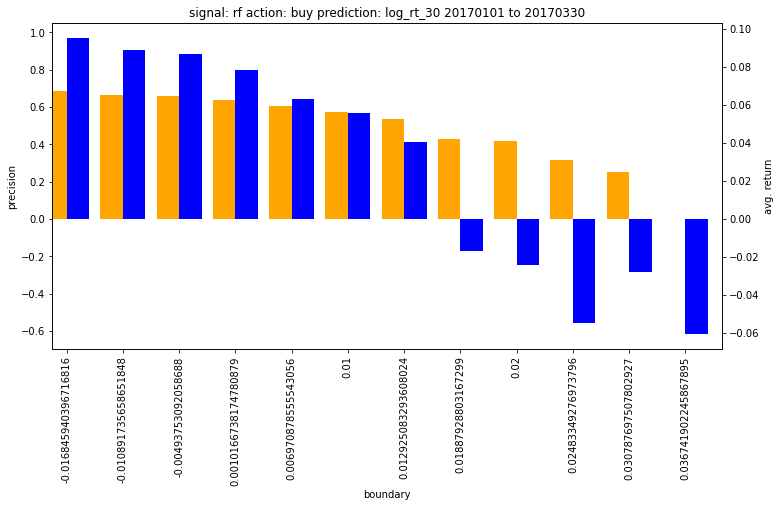

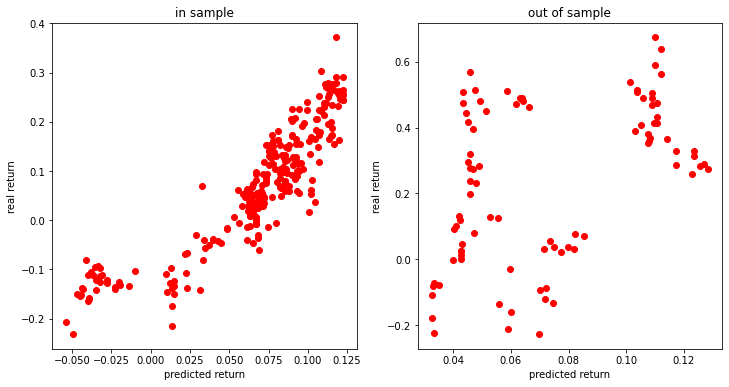

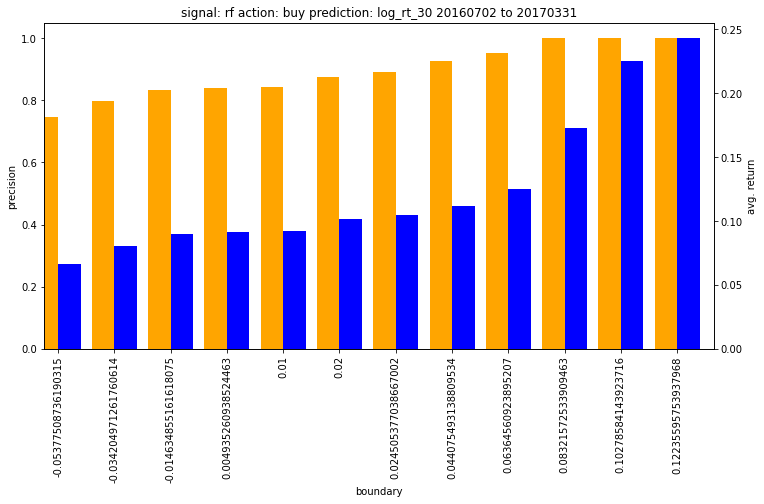

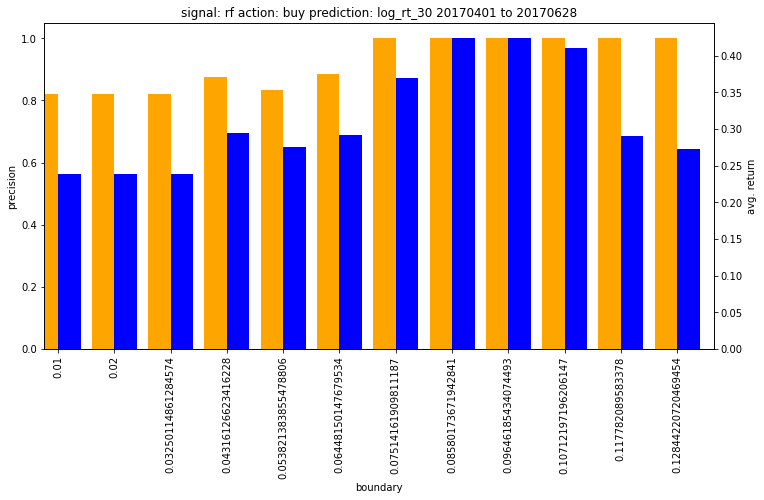

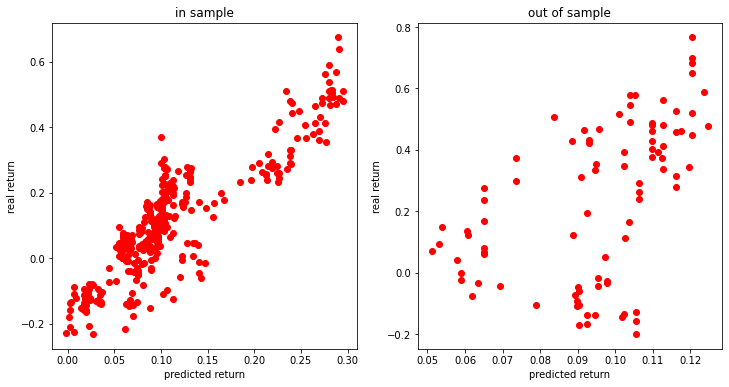

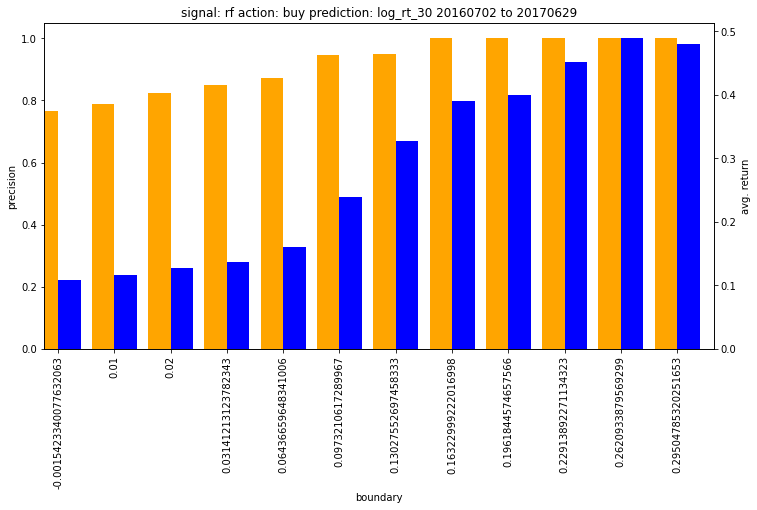

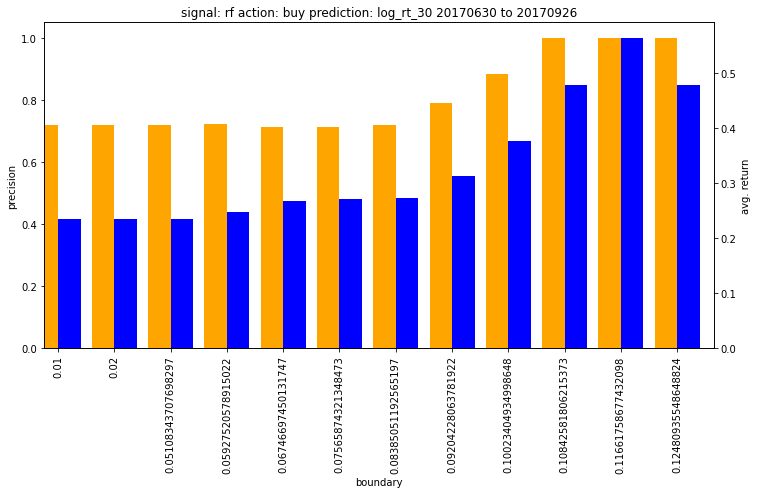

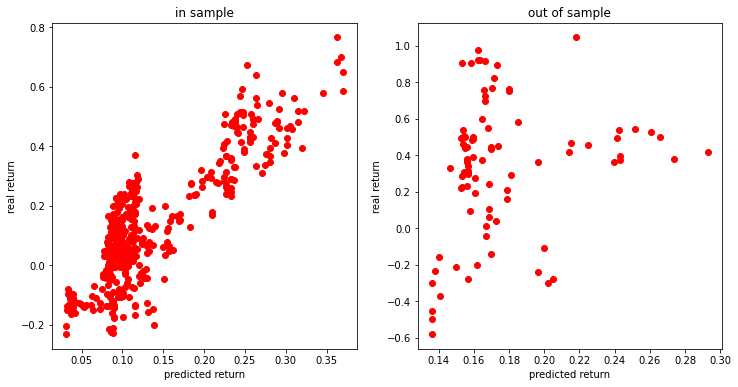

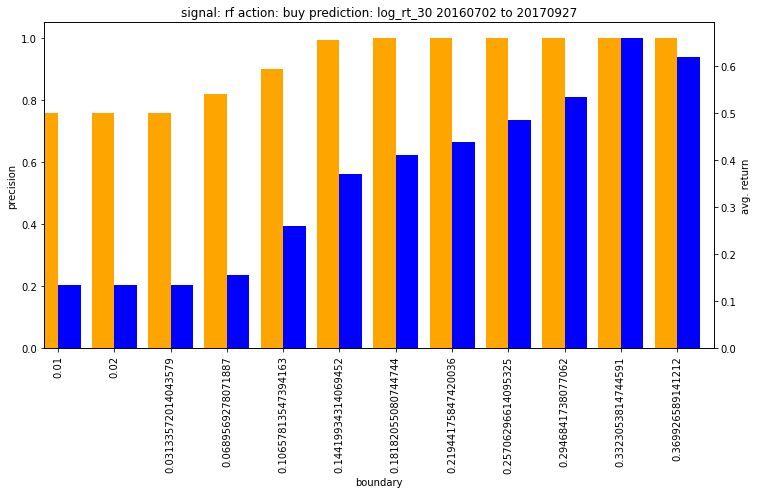

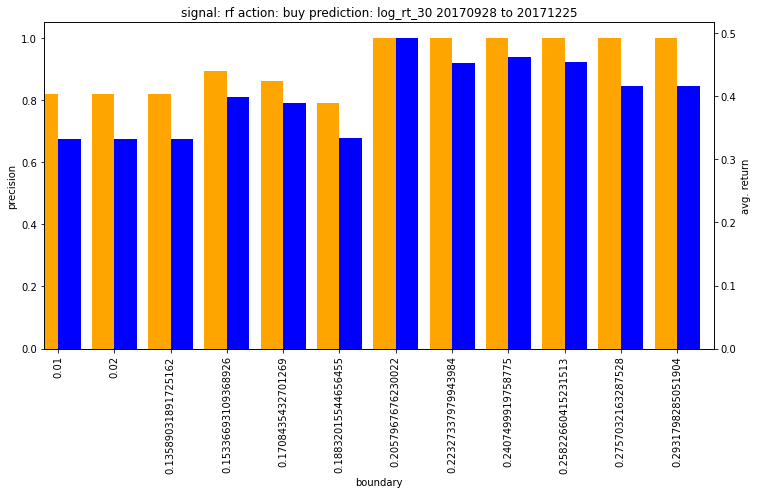

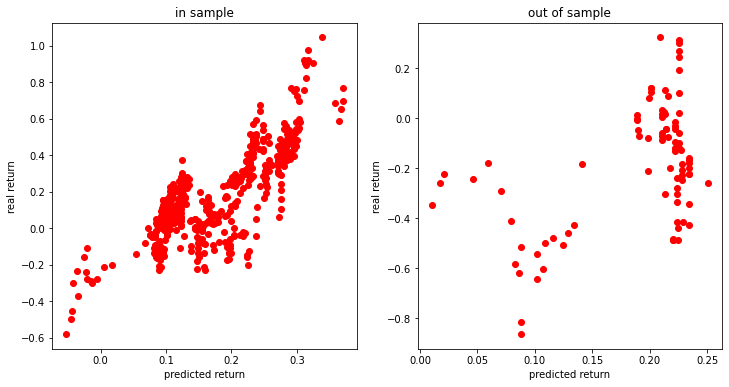

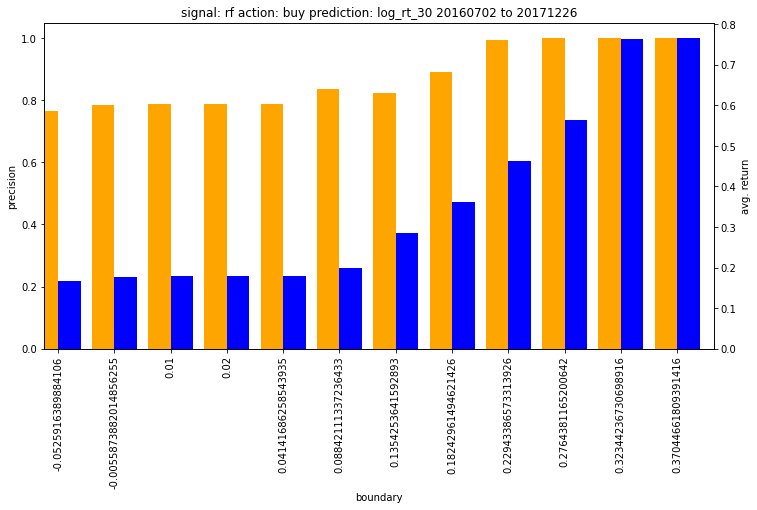

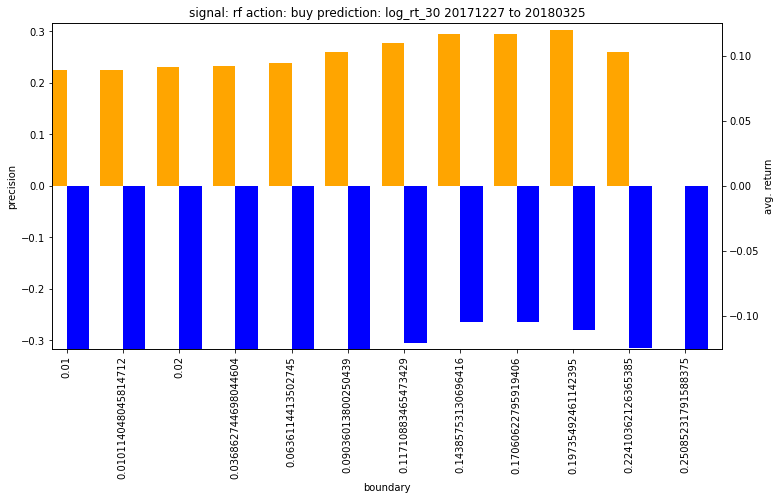

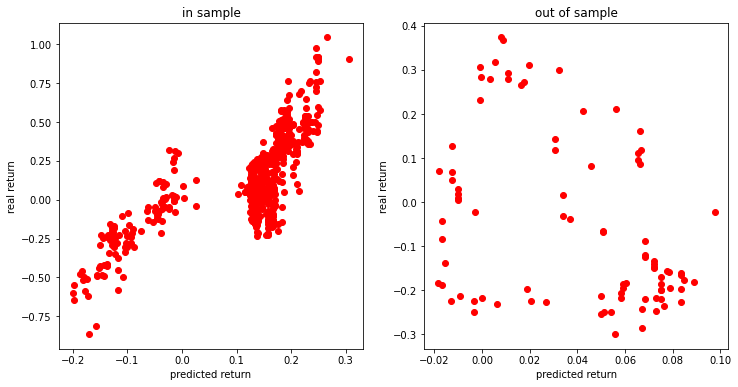

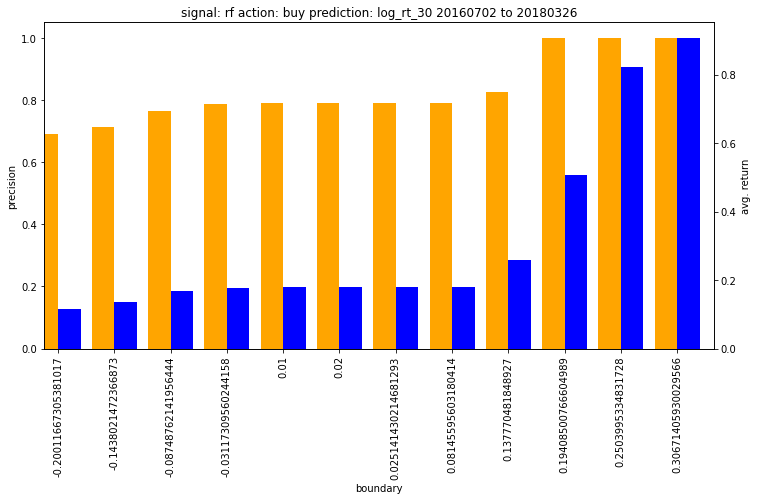

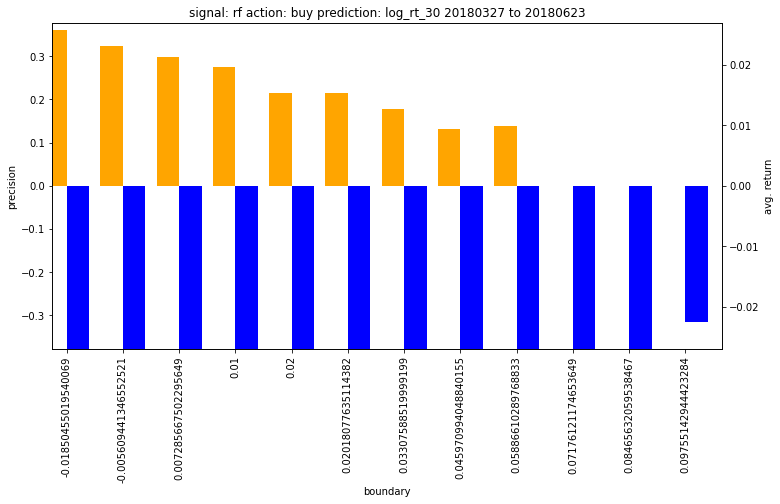

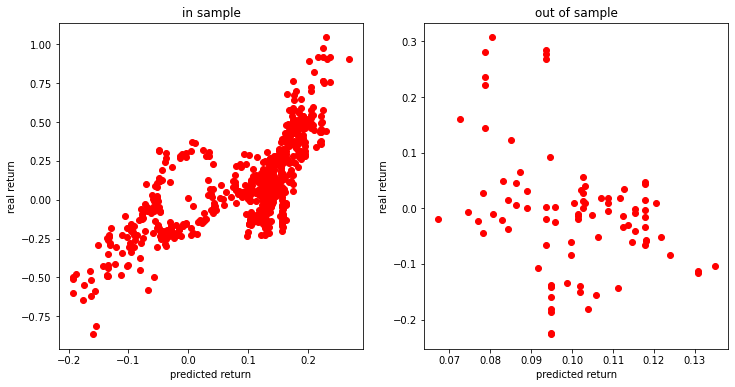

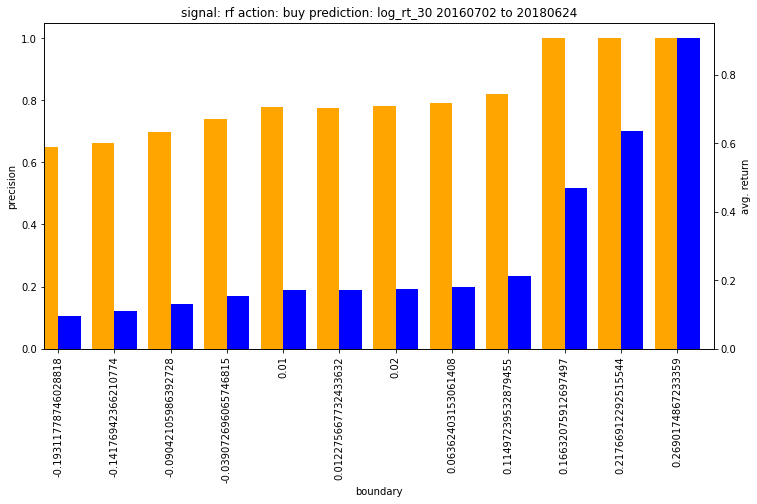

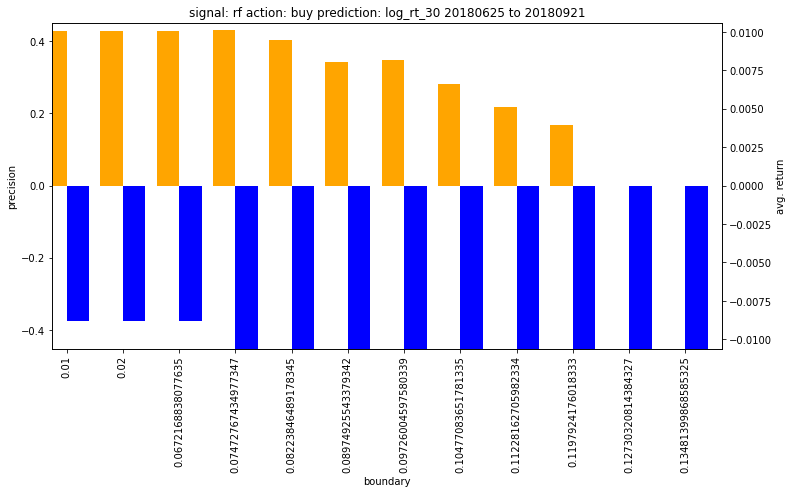

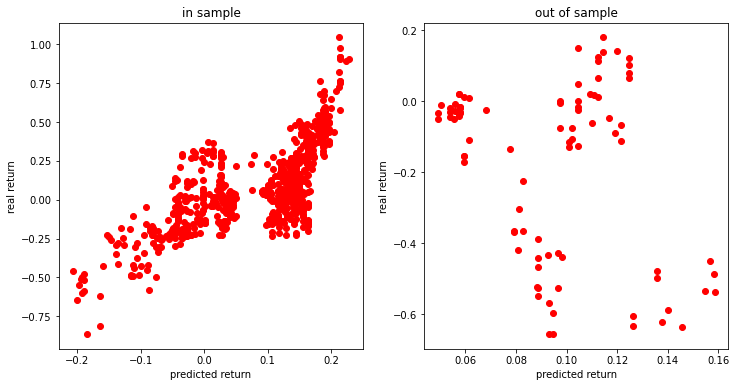

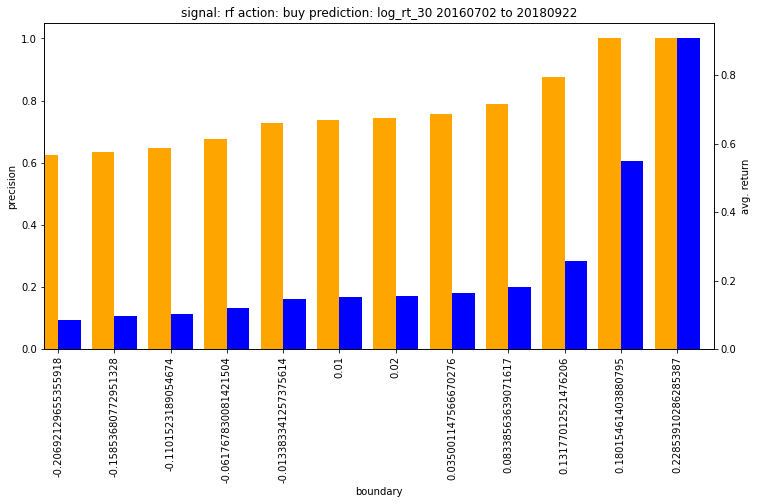

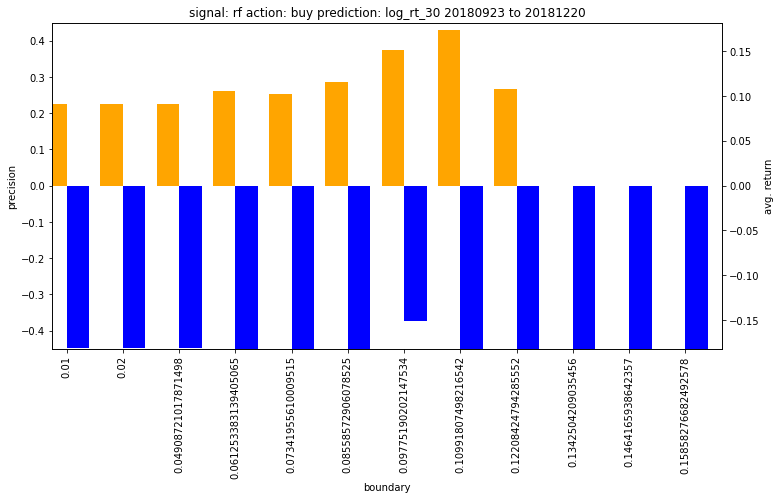

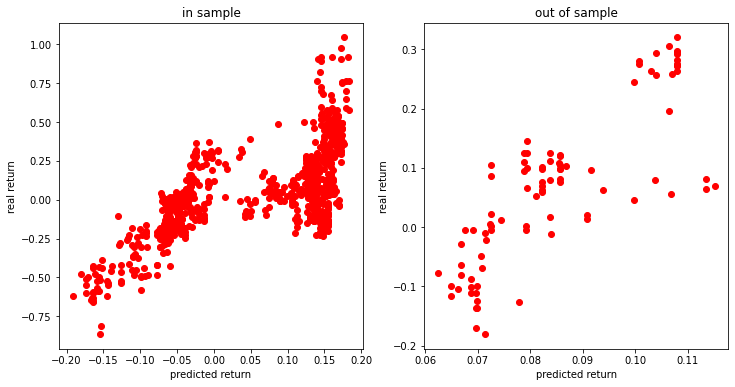

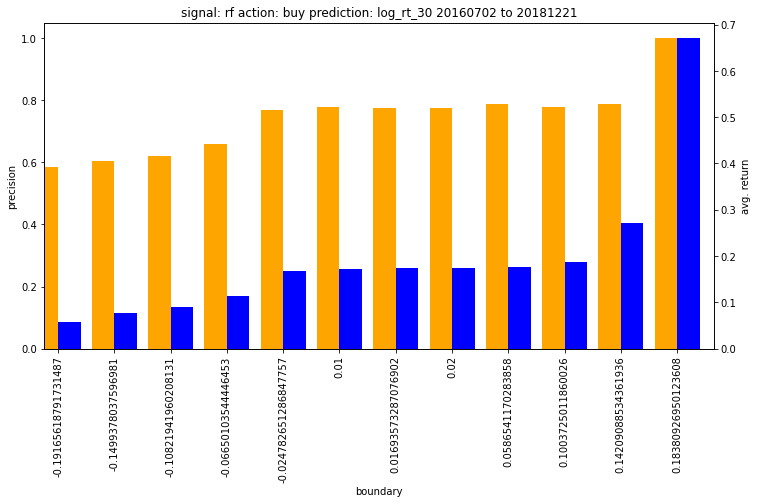

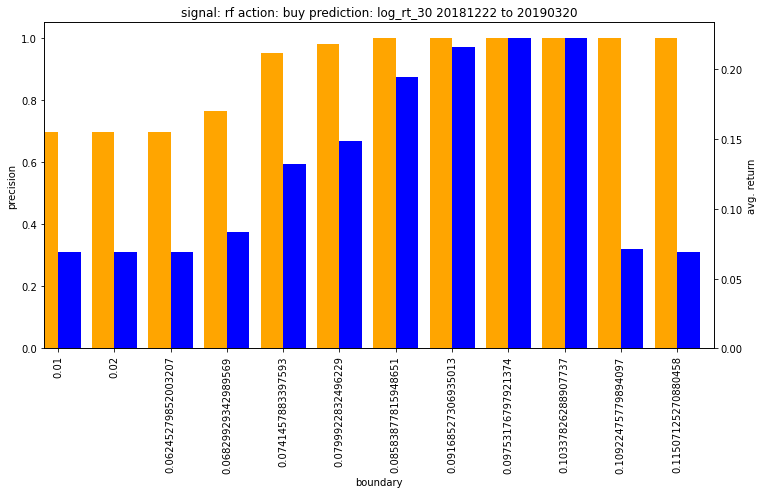

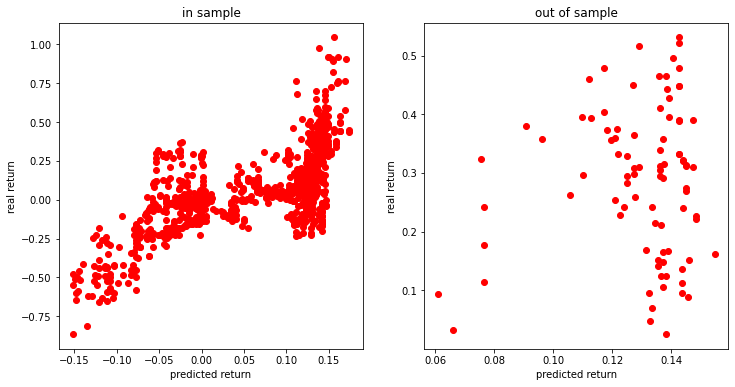

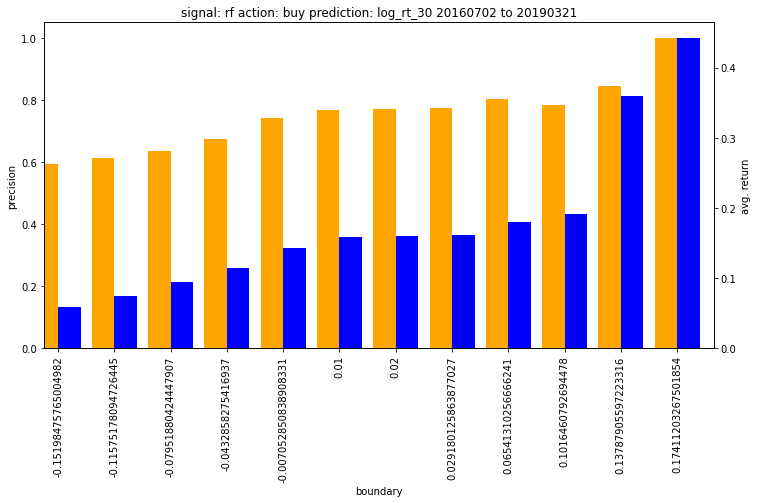

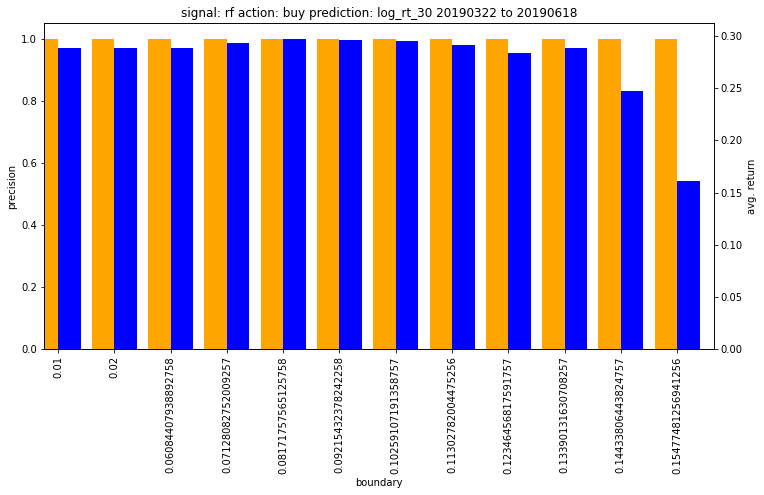

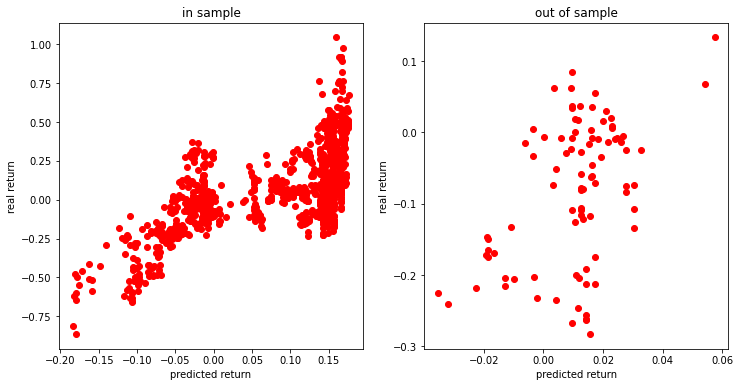

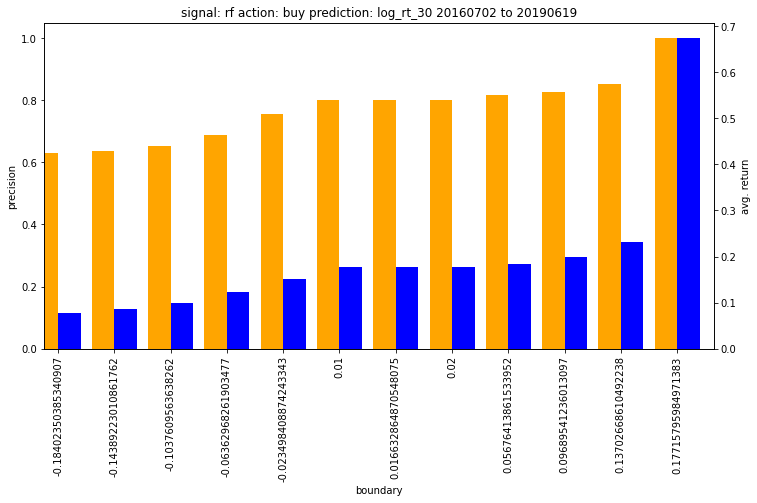

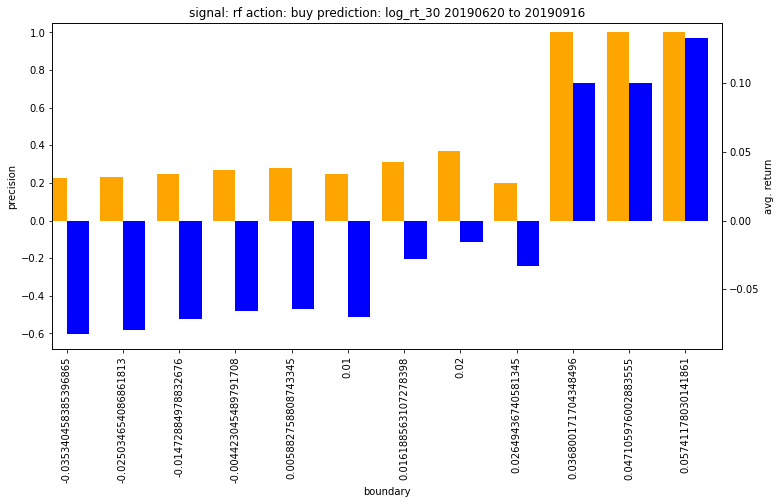

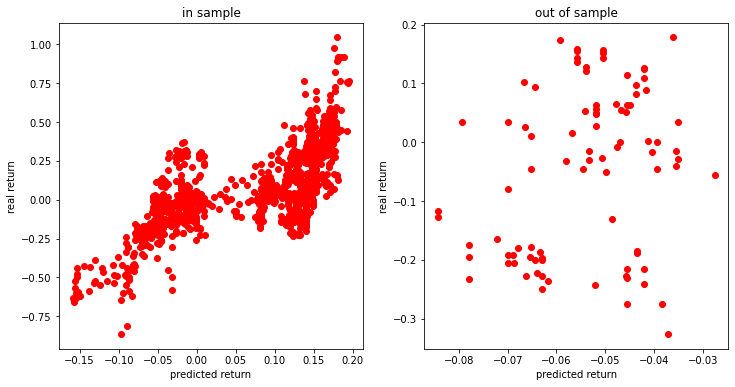

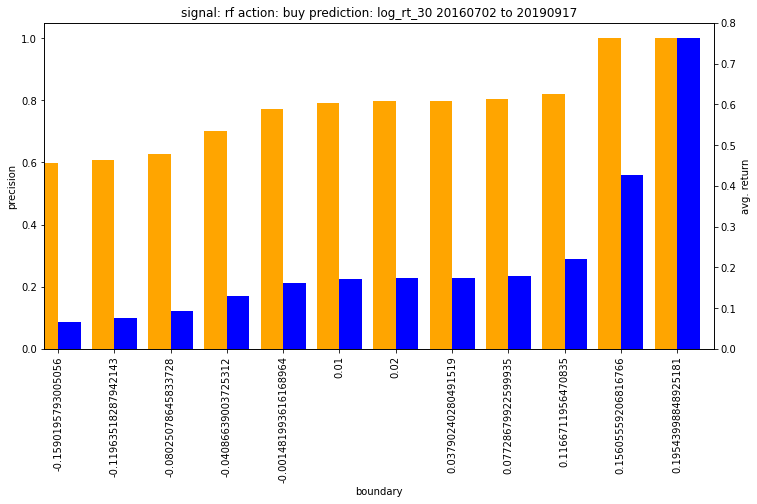

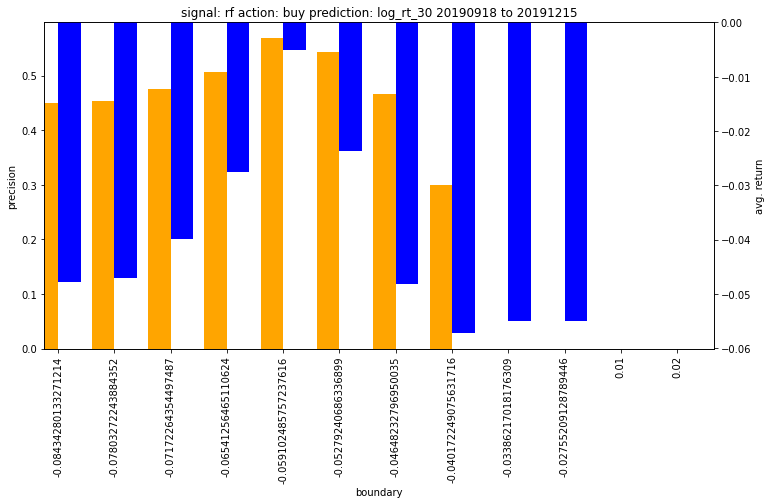

In [439]:
ml.fit_compo_index(X,Y,'rf',target)